In [1]:
import numpy as np
import time
import generalized_genSim_shorten_time_HMM as ggsdHMM
import numpy as np
import curve_fitting as cf
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#import matplotlib.cm as cmx
from scipy import optimize, stats
import bluepyopt as bpop
import bluepyopt.deapext.algorithms as algo
import vclamp_evaluator_HMMtoHH as vcl_ev
import pickle
import time
from deap import tools
#from deap import base, creator
import multiprocessing
#import eval_helper as eh
#import scoring_functions_relative as sf
#import curve_fitting as cf
import generalized_genSim_shorten_time as ggsd
import eval_helper_na12mut8st as ehn

Reached import hoc
Reached import neuron.hoc


In [10]:
evaluator = vcl_ev.Vclamp_evaluator_HMM('./csv_files/params_na12mut8st_mod_wide.csv', 'Basis', 'na12mut8st', 'na12mut', objective_names=['act', 'inact', 'tau0', 'peak_amp', 'time_to_peak'])


#evaluator = vcl_ev.Vclamp_evaluator_HMM('./param_stats_narrow.csv', 'A427D', 'na', objective_names=['v_half_act', 'gv_slope', 'v_half_ssi', 'ssi_slope'])

In [11]:
evaluator.wild_data



{'v_half_act': -19.438432175828535,
 'gv_slope': 6.1618554048712015,
 'v_half_ssi': -44.72164146029349,
 'ssi_slope': 7.055442056187008,
 'tau_fast': 0.8927258721940866,
 'tau_slow': 1.1909104890546904,
 'percent_fast': 0.002371458641170018,
 'tau0': 0.4231792451831216,
 'peak_amp': -0.29202235337531235,
 'time_to_peak': 5.20000000000004}

In [12]:
gen_counter = 0
best_indvs = []
cp_freq = 1
old_update = algo._update_history_and_hof
def my_update(halloffame, history, population):
    global gen_counter,cp_freq
    if halloffame is not None:
        halloffame.update(population)
    
    if halloffame:
        best_indvs.append(halloffame[0])
    gen_counter = gen_counter+1
    print("Current generation: ", gen_counter)
    if gen_counter%cp_freq == 0:
        fn = '.pkl'
        save_logs(fn,best_indvs,population)

def my_record_stats(stats, logbook, gen, population, invalid_count):
    '''Update the statistics with the new population'''
    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=gen, nevals=invalid_count, **record)
    print('log: \n', logbook, '\n')
    output = open("log.pkl", 'wb')
    pickle.dump(logbook, output)
    output.close()

def save_logs(fn, best_indvs, hof):
    output = open("indv"+fn, 'wb')
    pickle.dump(best_indvs, output)
    output.close()
    output = open("hof"+fn, 'wb')
    pickle.dump(hof, output)


In [13]:
#hof = tools.HallOfFame(1, similar=np.array_equal)
hof = tools.ParetoFront()
algo._update_history_and_hof = my_update
algo._record_stats = my_record_stats
pool = multiprocessing.Pool(processes=64)
deap_opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=100, hof = hof, map_function=pool.map)  # CHANGE offspring_size

cp_file = './cp.pkl'

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.
Couldn't fit curve to activation.
Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of t

Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of t

Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of t

Couldn't fit curve to activation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of t

Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.
Couldn't generate tau0 data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.
Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data
Couldn't generate tau0 data
Couldn't generate activation data
Couldn't generate tau0 data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data
Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.
Couldn't generate activation data
Couldn't fit curve to activation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate tau0 data
Couldn't generate tau0 data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.
Couldn't fit curve to activation.
Couldn't generate activation data
Couldn't fit curve to inactivation.
Couldn't generate activation data


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't generate activation data
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't generate activation data
Couldn't generate activation data
Couldn't generate tau0 data
Couldn't fit curve to activation.
Couldn't fit curve to activation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't generate activation data
Couldn't fit curve to inactivation.
Couldn't generate activation data
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to activation.
Couldn't generate activation data
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't generate activation data
Couldn't generate activation data
Couldn't fit curve to activation.
Couldn't fit curve to activation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't generate activation data
Couldn't fit curve to activation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate activation data
Couldn't generate activation data
Couldn't generate tau0 data
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit

In [18]:
start_time = time.time()
pop, hof, log, hst = deap_opt.run(max_ngen=5, cp_filename=cp_file)  # CHANGE max_ngen
end_time = time.time()
print(end_time - start_time)

Current generation:  6
log: 
 gen	nevals	avg        	std        	min   	max        
1  	100   	9.99405e+07	4.35562e+08	163.93	1.99859e+09 

Current generation:  7
log: 
 gen	nevals	avg        	std        	min   	max        
1  	100   	9.99405e+07	4.35562e+08	163.93	1.99859e+09
2  	100   	8.99441e+07	4.143e+08  	163.93	1.99859e+09 

Current generation:  8
log: 
 gen	nevals	avg        	std        	min    	max        
1  	100   	9.99405e+07	4.35562e+08	163.93 	1.99859e+09
2  	100   	8.99441e+07	4.143e+08  	163.93 	1.99859e+09
3  	100   	6.99839e+07	3.67275e+08	20.8212	1.99849e+09 

Current generation:  9
log: 
 gen	nevals	avg        	std        	min    	max        
1  	100   	9.99405e+07	4.35562e+08	163.93 	1.99859e+09
2  	100   	8.99441e+07	4.143e+08  	163.93 	1.99859e+09
3  	100   	6.99839e+07	3.67275e+08	20.8212	1.99849e+09
4  	100   	1.20012e+08	4.74595e+08	20.8212	1.99859e+09 

Current generation:  10
log: 
 gen	nevals	avg        	std        	min    	max        
1  	100   	9.99405e+0

In [9]:
print(log)

gen	nevals	avg    	std    	min    	max    
1  	100   	227.529	188.041	15.0031	570.972
2  	100   	226.227	185.785	15.0031	574.892


In [15]:
evaluator.evaluate_with_lists(best_indvs[-1])

[8.771743969079944,
 10.441642799231156,
 0.004507444228712106,
 0.0004633923529886812,
 0.0006250000000000178]

In [3]:
import eval_helper as eh
eh.change_params([7.469160595102233, 0.1110309461516207, 0.09834011757279898, 1.959729160651832, 1491.0890579477725, 0.9777458769346035, 45.97790651811909, 4.882721940602804, 242.65899105292436, 2.5542201851262116, 3.09332385731855, 0.3596166292564826, 175.64752705910956, 13.719069975558211, 1.4023566772303253, 0.14909624523920945, 2158.0900150490675, 0.4841273939654566, 21.95876324483144, 16.98204089057011], scaled=False, is_HMM=True)

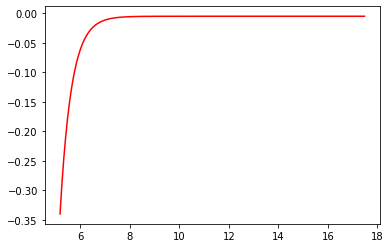

0.45991406031792237

In [4]:
ehn.find_tau0(make_plot=True)

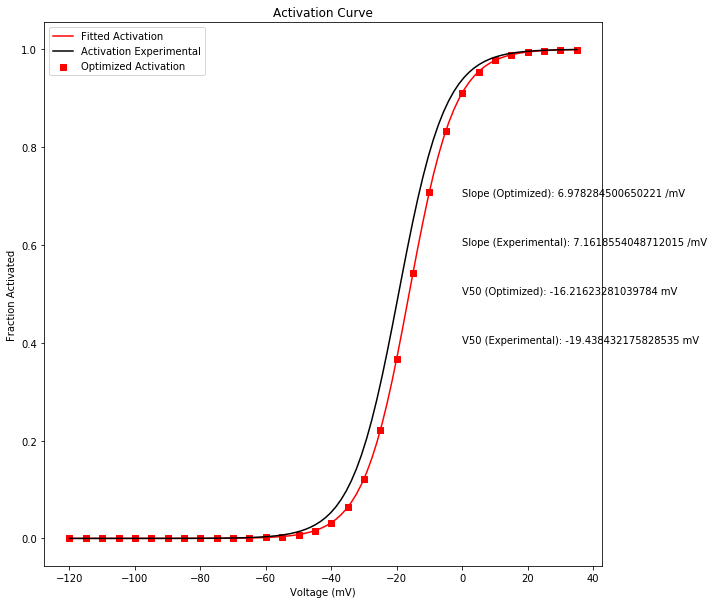

In [5]:
evaluator.plot_act([7.469160595102233, 0.1110309461516207, 0.09834011757279898, 1.959729160651832, 1491.0890579477725, 0.9777458769346035, 45.97790651811909, 4.882721940602804, 242.65899105292436, 2.5542201851262116, 3.09332385731855, 0.3596166292564826, 175.64752705910956, 13.719069975558211, 1.4023566772303253, 0.14909624523920945, 2158.0900150490675, 0.4841273939654566, 21.95876324483144, 16.98204089057011])

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


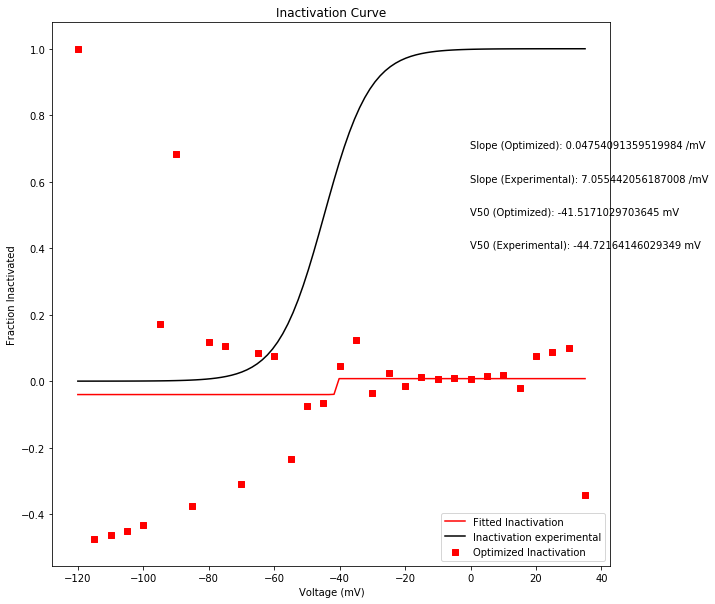

In [3]:
evaluator.plot_inact([8610.664231882518, 74.75851866974136, 17.104243863945157, 352.99430555853854, 159732.0152569037, 117.05001128794483, 429.26804042616453, 199.26882466705985, 37678.34886458242, 118.53666744034817, 1708.165873119983, 1.1468328867199773, 1668.329683807575, 585.2290227247271, 3.3668969813665797, 55.52482130437654, 115425.77482347324, 180.91922240148966, -467.27152862801887, 2482.178476592899])

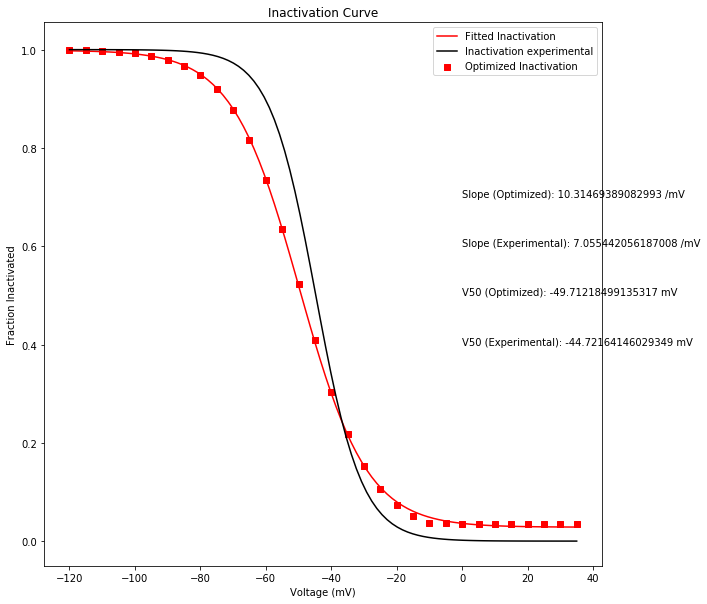

In [16]:
evaluator.plot_inact(best_indvs[-1])

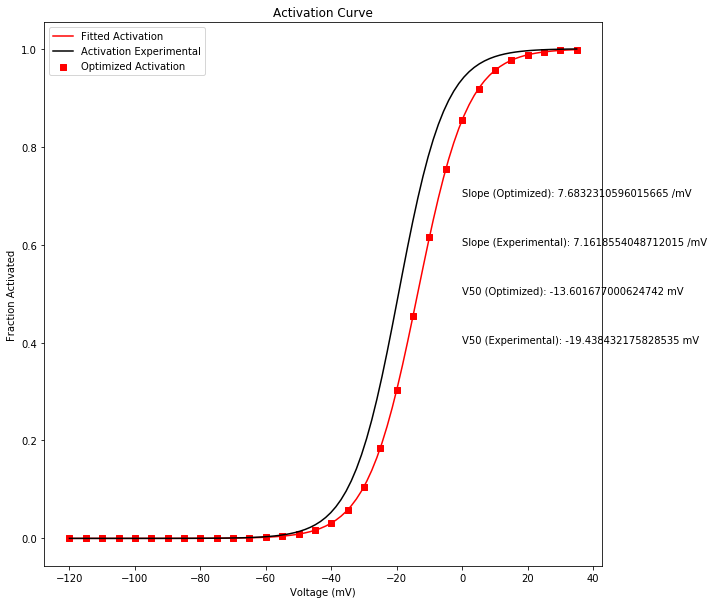

In [17]:
evaluator.plot_act(best_indvs[-1])

In [7]:
import eval_helper_na12mut as ehn
import eval_helper_na12mut8st as ehn8

In [8]:
ehn.find_time_to_peak()

5.20000000000004

In [9]:
ehn8.find_time_to_peak()

5.17500000000004